In [13]:
import numpy as np
#from astropy import units as u
%matplotlib inline
import matplotlib.pyplot as plt
#from astropy.analytic_functions import \
#                blackbody_nu as bb_nu
from astropy import constants as const


class galsed():
    
    #Speed of light in um/s:
    c = 1e6*(const.c).value
    h = (const.h).value
    kb = (const.k_B).value
    
    def __init__(self, \
                 norm=1., temp=25., beta=1.5, \
                 plnorm=0.5, alpha=2., turnover=50., \
                 pah=0.1):
        
        #Set the wavelength array; can be changed with setwav():    
        self.wav = np.logspace(np.log10(5),np.log10(1000),1024)
        self.nu = self.c/self.wav
        
        #Set default BB properties; can be changed with setbb():    
        self.bb_norm = norm    
        self.bb_temp = temp
        self.beta = beta
        
        #Set default PL properties; can be changed with setpl:
        self.relnorm = plnorm
        self.alpha = alpha
        self.tp = turnover
        
        #Set default PAH norm (as fraction of LIR?):
        #read in the PAH template and interpolate.
        self.pahnorm = pah
        self.pwav, self.pflux = np.loadtxt('M11_SEDs/avg_pah.dat', \
                                 comments='#', \
                                 unpack=True)  
        self.pah = np.interp(self.wav,self.pwav,self.pflux,\
                             left=0.,right=0.)
                                                        
    def setwav(self, wav):
        #(Re)Define the wavelength array (in microns):    
        self.wav = wav
        self.nu = self.c/self.wav
        self.pah = np.interp(self.wav,self.pwav,self.pflux,\
                             left=0.,right=0.)    
        
    def setbb(self, **kwargs):
        #(Re)Define the Blackbody parameters:
        #kwargs is used to maintain current values by default
        if 'norm' in kwargs: 
            self.bb_norm = kwargs.get('norm')
        if 'temp' in kwargs: 
            self.bb_temp = kwargs.get('temp')
        if 'beta' in kwargs: 
            self.beta = kwargs.get('beta')

    def setpl(self, **kwargs):
        #(Re)Define the Blackbody parameters:
        if 'plnorm' in kwargs:
            self.relnorm = kwargs.get('plnorm')
        if 'alpha' in kwargs:
            self.alpha = kwargs.get('alpha')
        if 'turnover' in kwargs:
            self.tp = kwargs.get('turnover')
        
    def setpah(self, pahnorm):
        self.pahnorm = pahnorm
        
    def getwav(self):
        return self.wav
    
    def bb(self, wav, temp):
        
        #Use own BB generator (ripped from astropy);
        #astropy's is slow, largely due to checks.
        nu = self.c/wav
        log_boltz = self.h * nu / (self.kb * temp)
        boltzm1 = np.expm1(log_boltz)
        return (2.0 * self.h * nu ** 3 / \
                (self.c ** 2 * boltzm1))
    
    def getbb(self):
        
        #Get the modified BB spectrum:    
        #Calculate normalisation:
        wavpeak = 2.9e3/self.bb_temp
        nupeak = self.c/wavpeak
        norm = self.bb_norm/((nupeak**self.beta)*\
                       self.bb(wavpeak, self.bb_temp))
        
        bb = self.bb(self.wav, self.bb_temp)
        return norm*bb*(self.nu**self.beta)
        
    def getpl(self):
        
        #Get PL spectrum:
        norm = self.bb_norm*self.relnorm/\
            ((self.tp**self.alpha)*np.exp(-1.))
        
        return norm*(self.wav**self.alpha)*\
                             np.exp(-(self.wav/self.tp)**2.)
    
    def getpah(self):
        return self.pahnorm*self.pah
    
    def getsed(self):
        return self.getpl()+self.getbb()+self.getpah()

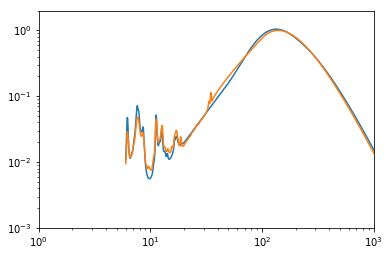

In [35]:
wav, flux = np.loadtxt('M11_SEDs/SB1.dat', \
                                 comments='#', \
                                 unpack=True)
flux = flux/np.max(flux)
a = galsed(alpha=2.5,turnover=90.)
a.setwav(wav)

a.setpl(plnorm=0.4, alpha=2.5)
a.setbb(norm=0.8,temp=21)
a.setpah(0.07)
plt.plot(a.getwav(), a.getsed(), wav, flux)
plt.axis([1,1000,1e-3,2])
plt.xscale('log')
plt.yscale('log')
plt.show()


